In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.graphics.api as smg
import statsmodels.stats.api as sms
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf
from scipy import stats
from matplotlib import pyplot as plt

import seaborn as sns

import pandas as pd
from sklearn import preprocessing

## Import the data

In [2]:
col_names = ["idname", "MDS", "weight", 
             "neg_risk_aversion", "neg_distortion", "neg_precision"]

# "pos_risk_aversion", "pos_distortion", "pos_precision"]

df = pd.read_excel(
    'data/summary_good.xlsx',
    usecols=col_names,
    index_col=0,
    sheet_name='data')

print(df)

        weight    MDS  neg_risk_aversion  neg_distortion  neg_precision
idname                                                                 
Abr       12.7  25.13          -0.013756        0.688844       0.733028
Ala       12.6  41.58          -0.413589        0.864891       1.651885
Alv       14.6  19.68          -0.287721        0.558478       0.712815
Anu       15.5  10.02          -0.682153        0.184130       0.642053
Bar       10.6  19.55          -0.868425        0.536097       2.172136
Ces        6.8 -30.86          -0.059548        0.794130       1.162504
Nem        9.2  11.75          -0.141133        0.640388       1.731826
Ner       11.9   9.67          -0.179254        0.442204       1.918406
Ola       16.5  39.04          -0.860058        0.706352       0.211054
Oli       15.0  52.12           0.106599        0.604000       1.649724
Pac       13.8   8.83          -0.990000        0.266652       0.917169
Yoh       10.0 -37.11          -0.872077        0.321017       1

In [3]:
# Normalize
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns,
             index=df.index)
print(df)

          weight       MDS  neg_risk_aversion  neg_distortion  neg_precision
idname                                                                      
Abr     0.608247  0.697523           0.890248        0.741397       0.266166
Ala     0.597938  0.881878           0.525635        1.000000       0.734712
Alv     0.804124  0.636445           0.640416        0.549897       0.255859
Anu     0.896907  0.528186           0.280729        0.000000       0.219776
Bar     0.391753  0.634988           0.110866        0.517020       1.000000
Ces     0.000000  0.070044           0.848489        0.896056       0.485166
Nem     0.247423  0.547574           0.774091        0.670219       0.775476
Ner     0.525773  0.524263           0.739328        0.379097       0.870617
Ola     1.000000  0.853413           0.118495        0.767115       0.000000
Oli     0.845361  1.000000           1.000000        0.616766       0.733610
Pac     0.721649  0.514849           0.000000        0.121221       0.360064

In [4]:
# Isolate predictors
predictor_names = [i for i in col_names if i not in ("idname", "MDS")]
predictors = df[predictor_names]

## Run regression analysis (OLS)

In [5]:
formula = "MDS ~ weight "
for i in predictor_names:
    formula += f"+ {i}"
res = smf.ols(formula=formula, data=df).fit()
print(formula)
print(res.summary())

MDS ~ weight + weight+ neg_risk_aversion+ neg_distortion+ neg_precision
                            OLS Regression Results                            
Dep. Variable:                    MDS   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     20.28
Date:                Tue, 12 May 2020   Prob (F-statistic):           0.000597
Time:                        13:48:25   Log-Likelihood:                 13.264
No. Observations:                  12   AIC:                            -16.53
Df Residuals:                       7   BIC:                            -14.10
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [6]:
print('Parameters: ', res.params)
print('R2: ', res.rsquared)

Parameters:  Intercept           -0.592644
weight               1.087470
neg_risk_aversion    0.044768
neg_distortion       0.489985
neg_precision        0.477592
dtype: float64
R2:  0.9205489231306193


## Compare the contribution of each predictor

### Partial regression plot
Show the effect of adding another predictor to a model that already contains the other predictors

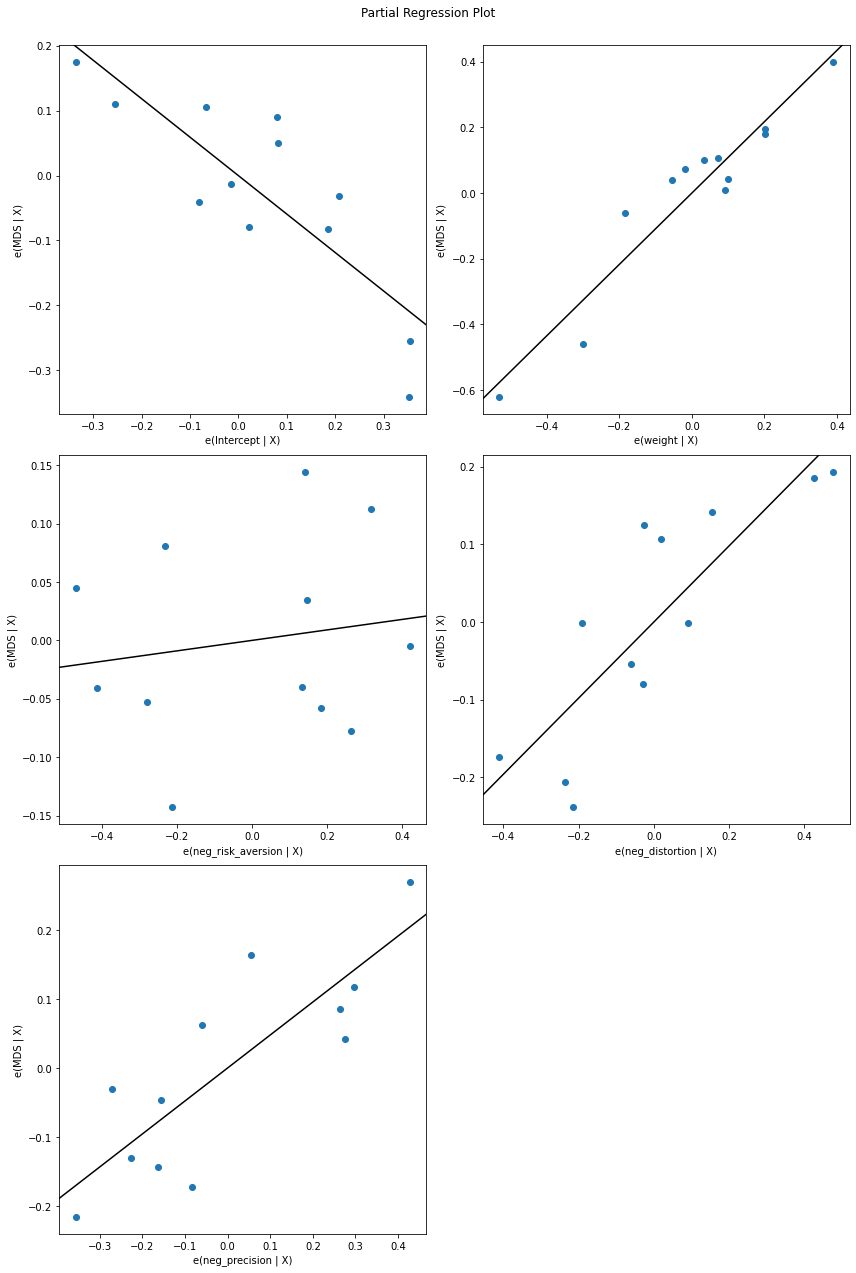

In [7]:
fig = plt.figure(figsize=(6*2, 6*3))
fig = sm.graphics.plot_partregress_grid(res, fig=fig)

### Component and component plus residual plots (partial residual plot)

Quite useless in the case of a single predictor (at this point, a scatter plot of the dependant variable vs the predictor value is enough), but useful in the case of multiple predictors. Contrary to dependant vs each predictor, the effect of other predictors is taken into account in these plots.

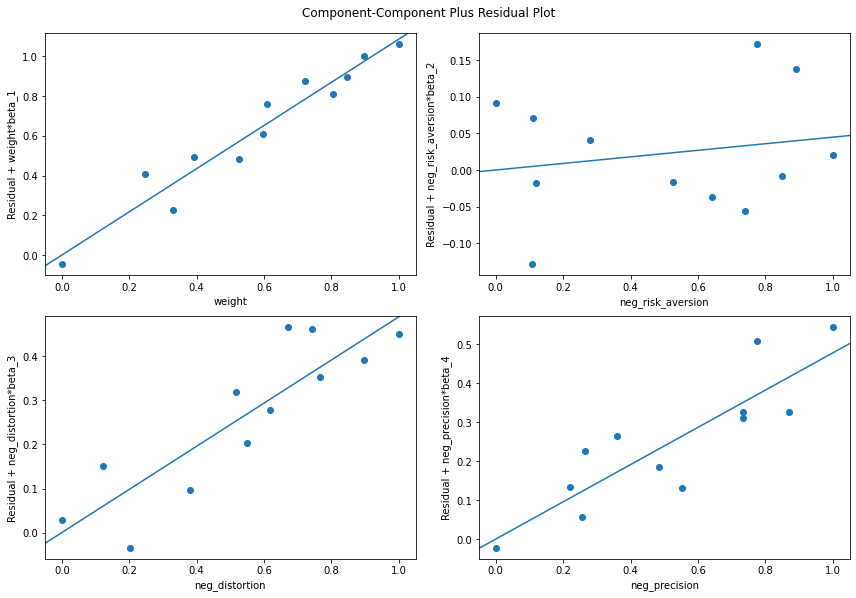

In [8]:
fig = plt.figure(figsize=(6*2, 6*int(len(predictor_names)/2)))
fig = sm.graphics.plot_ccpr_grid(res, fig=fig)

## Regression diagnostics
### Check for normality of residuals

In [9]:
# Statistical tests (H0 = dist is non-normal)
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(res.resid)
for n, m in zip(name, test):
    print(n, m)

Jarque-Bera 0.6451860873916649
Chi^2 two-tail prob. 0.7242685400500337
Skew 0.17519412326416567
Kurtosis 1.919444470895581


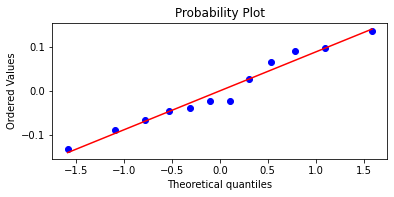

In [10]:
# Normal probability plot
fig, ax = plt.subplots(figsize=(6, 2.5))
stats.probplot(res.resid, plot=ax, fit=True)
plt.show()

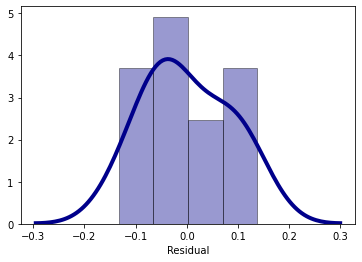

In [11]:
# Distribution of residuals
sns.distplot(res.resid, hist=True, kde=True,
             bins=4,
             color='darkblue',
             hist_kws={'edgecolor': 'black'},
             kde_kws={'linewidth': 4},
             axlabel='Residual'
            )
plt.show()

### Check for (absence of) multicollinearity between predictors

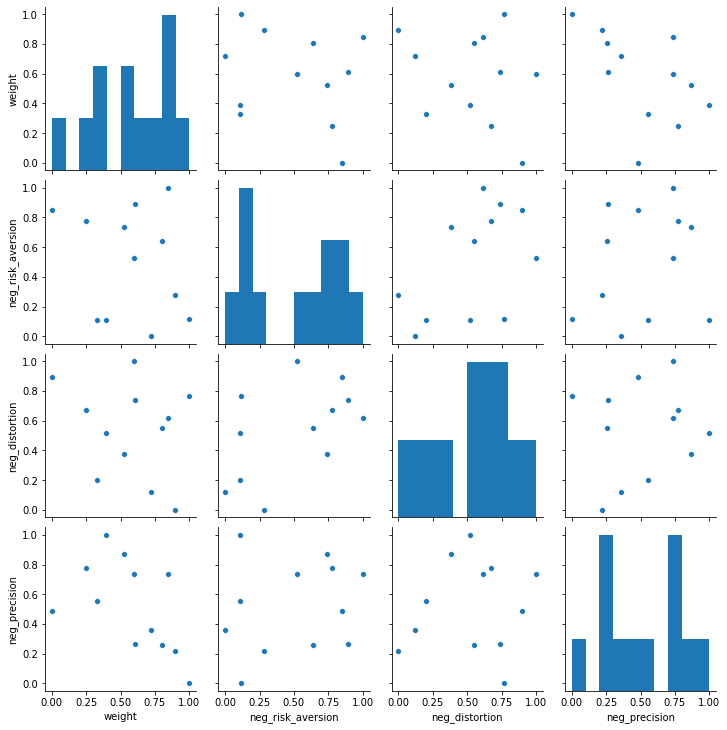

In [12]:
sns.pairplot(predictors)

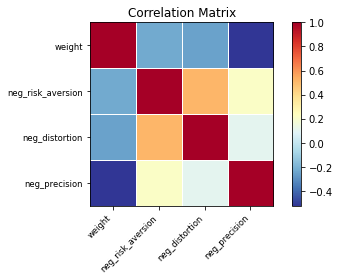

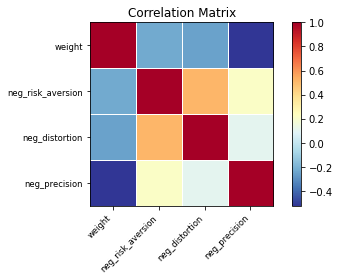

In [13]:
corr_matrix = predictors.corr(method='pearson')
smg.plot_corr(corr_matrix, xnames=predictors.columns)

In [14]:
# Statistical test (H0 = multicollinearity)
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sm.stats.diagnostic.het_breuschpagan(res.resid, res.model.exog)
for n, m in zip(name, test):
    print(n, m)

Lagrange multiplier statistic 4.4649906482027735
p-value 0.3467188912704397
f-value 1.0369905688957304
f p-value 0.45166740523580357


In [15]:
# Condition number (the bigger, the better; 0=> maximal multicollinearity)
np.linalg.cond(res.model.exog)

10.266340419359263

### Check for homoscedasticity of residuals
What we don't want is heteroscedasticity => systematic change in the spread of the residuals over the range of measured values

Text(0, 0.5, 'Residuals (normalized)')

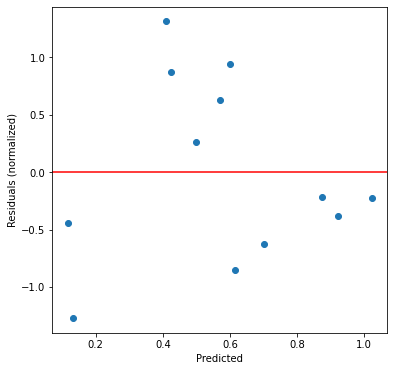

In [16]:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(res.predict(), res.resid_pearson)
    ax.axhline(0, color='red')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals (normalized)")

### Check for linearity

Text(0, 0.5, 'Observed')

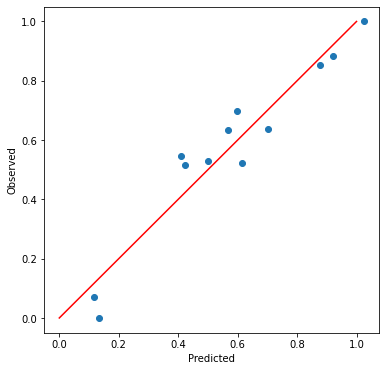

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(res.predict(), df["MDS"])
ax.plot((0,1), (0, 1), color="red")
ax.set_xlabel("Predicted")
ax.set_ylabel("Observed")

In [18]:
# Check esperance of error (should be zero)
res.resid.mean()

-1.3646491344350883e-16

In [19]:
# Statistical test
name = ['t value', 'p value']
test = sms.linear_harvey_collier(res)
for n, m in zip(name, test):
    print(n, m)

t value nan
p value nan


/usr/local/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:1635: RuntimeWarning: invalid value encountered in sqrt
  rresid_scaled = rresid / np.sqrt(rvarraw)  # N(0,sigma2) distributed


**NB: The partial regression plot are also useful to check the linearity**

### Influence tests
Assess the influence of each data point on the model

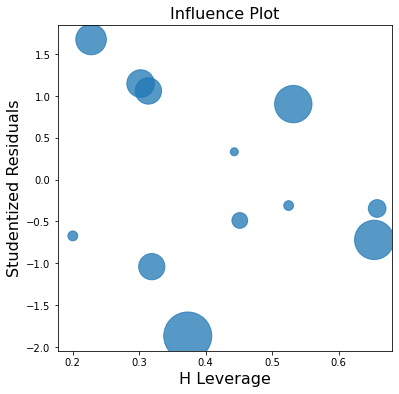

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = sm.graphics.influence_plot(res, ax=ax, criterion="cooks")